## Import Data From Kaggle using kaggle API

In [1]:
#Downloading the dataset using the google API
!pip install -q kaggle

In [2]:
from google.colab import files
import os

In [7]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ndujudeleonard","key":"511ee44003af9f68a82568d69eaa662c"}'}

In [4]:
!mkdir ~/.kaggle

In [8]:
!cp kaggle.json ~/.kaggle/  #make diredtory named kagggle and copy kaggle.jason file there

In [9]:
!chmod 600 ~/.kaggle/kaggle.json  #change permission of file

In [10]:
!kaggle datasets list  # checking a list of available competition

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-07-07 19:18:09           9023  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5526  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1996  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2382  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [11]:
# downlaod dog vs cats dataset into colab
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.5MB/s]
100% 543M/543M [00:04<00:00, 210MB/s]
100% 543M/543M [00:05<00:00, 114MB/s]
 98% 265M/271M [00:01<00:00, 199MB/s]
100% 271M/271M [00:01<00:00, 176MB/s]


In [ ]:
# make directory for train where we can unzip files content
!mkdir dc_train 
!unzip train.zip -d dc_train

In [ ]:
# make directory for test where we can unzip files content
!mkdir dc_test 
!unzip test1.zip -d dc_test

In [14]:
!rm *.zip  # deleting all the zip files

In [15]:
%ls

 dc_test/   'kaggle (1).json'   sample_data/
 dc_train/   kaggle.json        sampleSubmission.csv


In [16]:
for i in os.listdir('dc_train'):  # printing the name of the file containing the images in train data
  print(i)

train


In [17]:
for i in os.listdir('dc_test'):  # printing the name of the file containing the images in test data
   print(i)

test1


In [18]:
# read to files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
# locate file path
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is located in the Googlr Drive

In [20]:
#import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator 

In [21]:
train_path = "./dc_train/train"
test_path = "./dc_test/test1"

In [22]:
# we will work with just the train data to quickly look up what our data looks like before setting a portion of it for training
filenames = os.listdir(train_path)
categories = [] # create an empty list to store values
for path in filenames:
  animal_type = path.split('.')[0]
  categories.append(animal_type)

In [23]:
# create a dataframe with the list stored values with assigned field names
df = pd.DataFrame({'Image': filenames, 'Animal': categories})
df.sample(5)

,Image,Animal
16662,dog.4182.jpg,dog
2560,cat.4973.jpg,cat
24930,cat.8512.jpg,cat
18235,cat.8848.jpg,cat
8399,dog.5300.jpg,dog


In [24]:
# Here we use scikit-learn to carve out 80% of our training data to train and 20% portion for validation
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

print("The shape of training data is:" + str(train_df.shape))
print("------------------------------")
print("The shape of validation data is:" + str(valid_df.shape))

The shape of training data is:(20000, 2)
------------------------------
The shape of validation data is:(5000, 2)


In [25]:
# Augmenting training data using ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1,
                                   height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
datagen_valid = ImageDataGenerator(rescale=1./255) # we rescale to normalize images between 0 and 1

In [26]:
aug_train = datagen_train.flow_from_dataframe(train_df, directory=train_path, x_col='Image', y_col='Animal', target_size=(224, 224), class_mode='binary',
                                              batch_size=64)
# augment for validation data
aug_valid = datagen_valid.flow_from_dataframe(valid_df, directory=train_path, x_col='Image', y_col='Animal', target_size=(224, 224),
                                              class_mode='binary', batch_size=64)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [27]:
# define model checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stp = EarlyStopping(monitor='val_accuracy', mode='max', patience=9, verbose=1)
reducelrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)
callbacks = [checkpoint, reducelrp, early_stp]

## Train Neural Network Model

In [28]:
# define Neural Network Model
model = Sequential()
# We create our first conv2D layer
# parse the number of times and direction our conv will pass through our image pixels to learn the pattern which is in (32, (3, 3))
# and then add a model dropout so the model dont over learn and start to over fit
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

# The second Con2D layer with (64, (3, 3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# The third Con2D layer with (128, (3, 3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

# We flatten all the conv layers we have created
# so we can easily feed it to the output model
model.add(Flatten())
model.add(Dense(1028, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='relu', kernel_initializer='he_uniform'))

# output channel
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile all the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

In [29]:
# fit and save model training to a variable to help visualize the train and validation performance
# This part takes approximately 5 hours to train using Colab GPU
# At 50 epochs gave an accuracy of 0.91, but takes a longer time to train
# for a quick generalisation, would set the epochs at 10
hist = model.fit(aug_train, validation_data=aug_valid, epochs=10, verbose=1, callbacks=callbacks)

Epoch 1/10
313/313 [==============================] - 308s 830ms/step - loss: 0.7348 - accuracy: 0.5742 - val_loss: 0.6714 - val_accuracy: 0.6040

Epoch 00001: val_accuracy improved from -inf to 0.60400, saving model to best_model.h5
Epoch 2/10
313/313 [==============================] - 260s 830ms/step - loss: 0.6186 - accuracy: 0.6395 - val_loss: 0.5557 - val_accuracy: 0.7042

Epoch 00002: val_accuracy improved from 0.60400 to 0.70420, saving model to best_model.h5
Epoch 3/10
313/313 [==============================] - 258s 823ms/step - loss: 0.6018 - accuracy: 0.6623 - val_loss: 0.5222 - val_accuracy: 0.7488

Epoch 00003: val_accuracy improved from 0.70420 to 0.74880, saving model to best_model.h5
Epoch 4/10
313/313 [==============================] - 261s 832ms/step - loss: 0.5655 - accuracy: 0.6898 - val_loss: 0.5054 - val_accuracy: 0.7524

Epoch 00004: val_accuracy improved from 0.74880 to 0.75240, saving model to best_model.h5
Epoch 5/10
313/313 [==============================] - 2

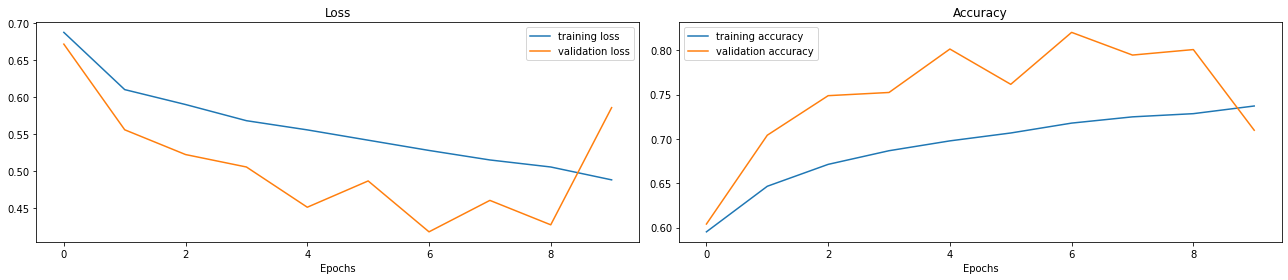

In [37]:
# Visualize performance for the training set

plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.title('Loss')
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.legend()

# Visualize performance for the validation set
plt.subplot(122)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
best_model = load_model('best_model.h5')

In [39]:
# navigating to test data directory for prediction
# create the same dataframe for the test set data
filenames = os.listdir(test_path)
test_df = pd.DataFrame({'Image':filenames})

test_df.sample(5)

,Image
8678,7499.jpg
7863,7329.jpg
8870,11289.jpg
3247,6948.jpg
7172,1041.jpg


In [40]:
# We apply the same preprocessing to our full test data
aug_test = datagen_valid.flow_from_dataframe(test_df, directory=test_path, x_col='Image', y_col='None', class_mode=None, target_size=(224, 224),
                                             batch_size=64, shuffle=False)

Found 12500 validated image filenames.


In [41]:
pred = best_model.predict(aug_test)

In [42]:
pred = np.where(pred > 0.5, 'Dog', 'Cat')

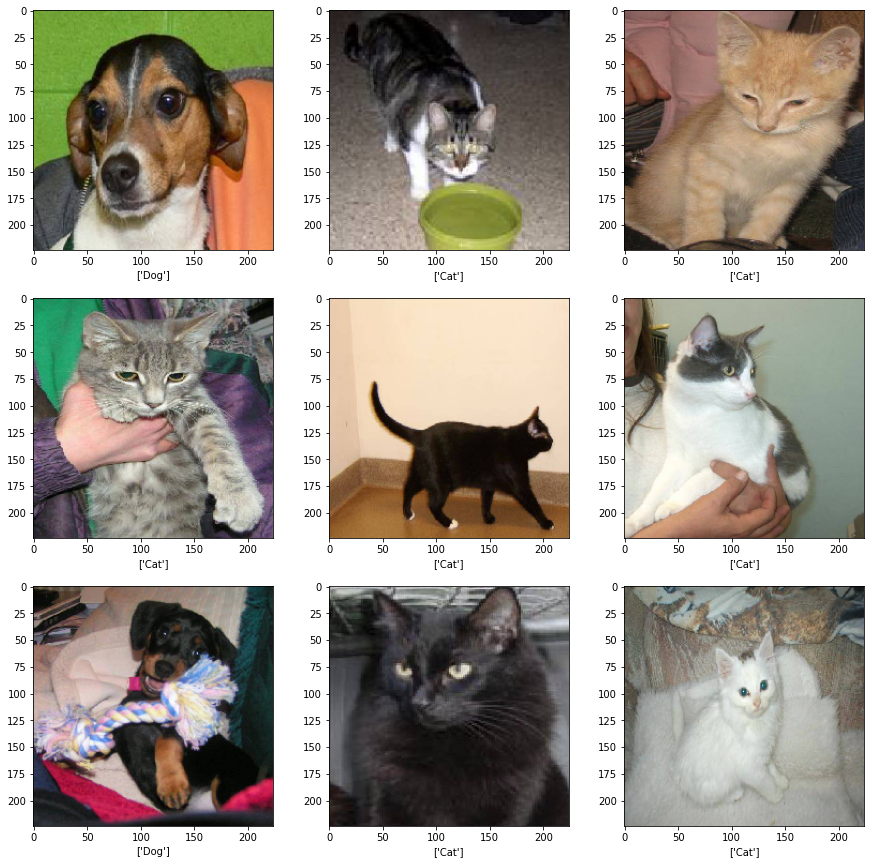

In [43]:
# Getting the predictions of 9 images in our test data
plt.figure(figsize=(15, 15))
for i in range(9):
  plt.subplot(3,3, i+1)
  plt.imshow(aug_test[0][i])
  plt.xlabel(pred[i])
plt.show()

In [44]:
# save model to a specifiede directory
!mkdir -p saved_model
best_model.save('saved_model/best_model.h5')

In [45]:
%ls

 best_model.h5   gdrive/            sample_data/
 dc_test/       'kaggle (1).json'   sampleSubmission.csv
 dc_train/       kaggle.json        saved_model/


In [49]:
best_model.save('best_model.h5')

NameError: ignored